## Examples of generated adversarial noise using ART and keras

In [2]:
import keras
from keras.models import load_model
from keras.datasets import mnist, fashion_mnist
from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.iterative_method import BasicIterativeMethod
from art.attacks.deepfool import DeepFool
import numpy as np

Using TensorFlow backend.


### Load data and model

In [3]:
# uncomment for loading fashion mnist
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_test = np.expand_dims(x_test, axis=3)
# convert class vectors to binary class matrices
class_9 = np.where(y_test == 9)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [7]:
# note that under models you can find for both datasets
classifier_model = load_model("models/mnist_cnn_original.h5")
classifier = KerasClassifier(classifier_model)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

### Generate Adversarial samples for both datasets

In [38]:
attacker_fgm = FastGradientMethod(classifier, eps=0.01)
x_test_adv_fg = attacker_fgm.generate(x_test[8500:])

In [52]:
x_test[8500:].shape

(1500, 28, 28, 1)

In [15]:
attacker_df = DeepFool(classifier)
x_test_adv_df = attacker_df.generate(x_test[8500:]) # np.full((1500, 1), 0))

In [ ]:
attacker_bim = BasicIterativeMethod(classifier, eps=0.01, max_iter=1000, eps_step=0.002)
x_test_adv_bim = attacker_bim.generate(x_test[8500:])

In [44]:
scores = classifier_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 125us/step
Test loss: 0.07132315555133055
Test accuracy: 0.9923


In [44]:
attacker_carlini = CarliniL2Method(classifier, confidence=0.0, targeted=False)
x_test_adv_cw = attacker_carlini.generate(x_test[8500:])

### Visualize adversarial samples

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

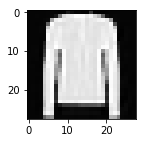

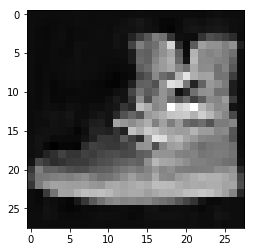

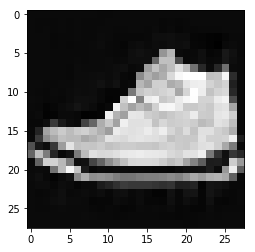

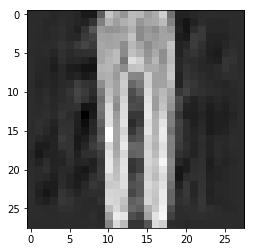

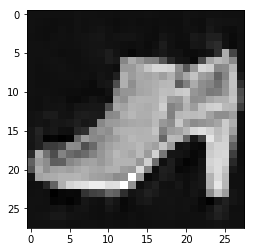

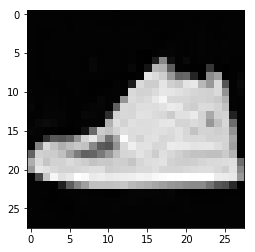

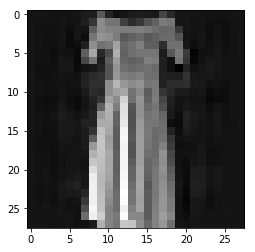

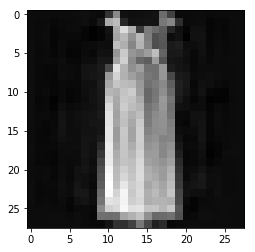

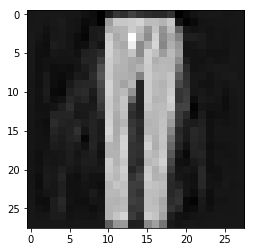

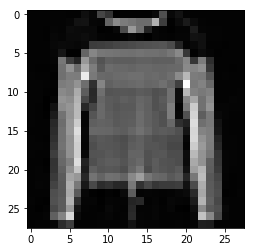

In [16]:
plt.figure(figsize=(2, 2))
for i in range(10):
    plt.imshow(x_test_adv_df[i].reshape(28, 28), cmap='gray')
    plt.show()


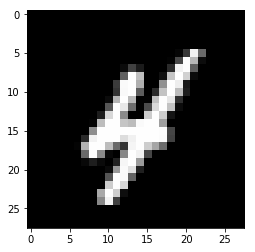

In [47]:
plt.imshow(clean[1208].reshape(28, 28), cmap='gray')

### Save background, clean and noised input for subset scanning test

In [46]:
#np.save('../ICLR/data/mnist_bg_7000.npy', x_test[:7000])
#np.save('../ICLR/data/mnist_clean_1500.npy', x_test[7000:8500])
np.save('../ICLR/data/mnist_other_clean.npy', x_test[8500:])

In [40]:
np.save('../ICLR/data/fmnist_class_9.npy', x_test[class_9])

### Save only noised images that success on the attack

In [18]:
for noised, name in zip([x_test_adv_df], ['DF']):
    x_test_adv_pred = np.argmax(classifier_model.predict(noised), axis=1)
    nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[8500:], axis=1))
    mask_correct = x_test_adv_pred != np.argmax(y_test[8500:], axis=1)
    noised_images = noised[mask_correct]
    print('*'*10)
    print("Adversarial test data (first 1500 images) for {}:".format(name))
    print("Correctly classified: {}".format(nb_correct_adv_pred))
    print("Incorrectly classified: {}".format(1500 - nb_correct_adv_pred))
    np.save('../ICLR/data/np_fmnist_df_cnn_keras.npy', noised_images)
    print(noised_images.shape)

**********
Adversarial test data (first 1500 images) for DF:
Correctly classified: 341
Incorrectly classified: 1159
(1159, 28, 28, 1)
